# GAN 

#### Select processing devices 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### Load Dependencies 

In [21]:
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Load Data 

In [7]:
input_images = "./quickdraw_data/apple.npy"

In [8]:
data = np.load(input_images)

In [9]:
data.shape

(144722, 784)

In [11]:
# data[4343]

#### normalize and reshape data 

In [12]:
data = data/255
data = np.reshape(data, (data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [14]:
# data[4343]

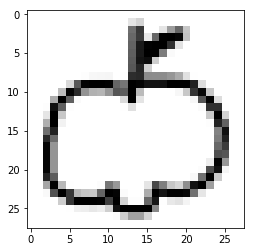

In [16]:
plt.imshow(data[4343, :, :, 0], cmap='Greys')

#### Create Discriminator network 

In [39]:
def discriminator_builder(depth=64,p=0.4):

    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [40]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 256)         0         
__________

In [41]:
discriminator.compile(loss='binary_crossentropy',
                     optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                     metrics=['accuracy'])

#### Create Generator network 

In [55]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [56]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_19 (Batc (None, 3136)              12544     
_________________________________________________________________
activation_19 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 14, 64)        0         
__________

#### Create Adversarial network 

In [57]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                 metrics=['accuracy'])
    
    model.summary()
    
    return model

In [58]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_3 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 390,577
Non-trainable params: 4,317,937
_________________________________________________________________


#### Train! 

In [59]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [60]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 7.987167, acc: 0.501002]  [A loss: 0.000000, acc: 1.002004]


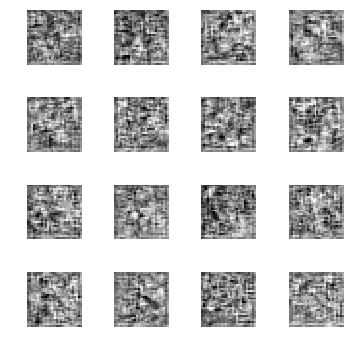

500
600
700
800
900
Epoch #1000
999: [D loss: 7.979172, acc: 0.500501]  [A loss: 0.000000, acc: 1.001001]


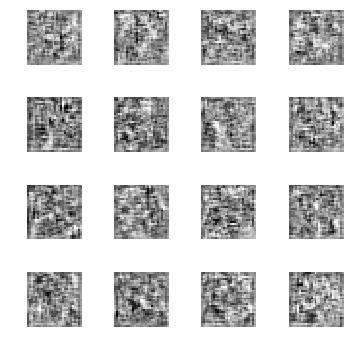

In [61]:
a_metrics_complete, d_metrics = train(epochs=1000)